<a href="https://colab.research.google.com/github/juhee3199/credit_score_predict/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas==1.2

Requirement already up-to-date: pandas==1.2 in c:\anaconda3\lib\site-packages (1.2.0)


In [ ]:
!pip install catboost
!pip install category_encoders

In [ ]:
!pip install pycaret

In [ ]:
#pip install statsmodels --upgrade

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import Counter
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import joblib

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from pycaret.classification import *
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

In [ ]:
train = pd.read_csv('credit_card_data/open/train.csv')
test = pd.read_csv('credit_card_data/open/test.csv')
submit =  pd.read_csv('credit_card_data/open/sample_submission.csv')

train.head()

,gender,car,reality,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,employed_y,ID,income_mean
0,1,1,1,1,1,1,1,-0.538321,-0.645632,-0.316977,1,-0.216262,-1.215242,1.0,-0.452672,0.994253,-1,0.002062
1,1,1,2,1,2,2,2,-0.538321,-0.645632,3.154805,2,0.897294,-1.275633,1.0,-1.060672,-0.250471,-1,-0.254157
2,2,2,2,2,1,1,2,-0.538321,1.548870,-0.316977,3,-0.216262,-0.248981,2.0,0.763330,0.994253,-1,1.693108
3,1,1,2,1,2,1,2,-0.538321,1.548870,-0.316977,4,-0.216262,0.656889,0.0,-0.192100,-0.094880,-1,0.002062
4,1,2,2,3,1,1,2,-0.538321,-0.645632,-0.316977,3,-0.216262,-0.007416,2.0,-0.192100,-0.094880,-1,-0.305401


# 1. 데이터 확인

In [ ]:
train.shape

(26457, 20)

- 데이터 형 변환

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
# credit 형 변환
train = train.astype({'credit': 'object'})

- 결측치 확인
      train, test 모두 occyp_type 컬럼에 결측치 존재

In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
test.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

# 2. EDA

### 1) Categorical Variable EDA

#### credit: 신용 등급 비율 (**target**)
- 낮을수록 높은 신용의 신용카드 사용자를 의미 
- 신용이 낮은 사용자가 많음

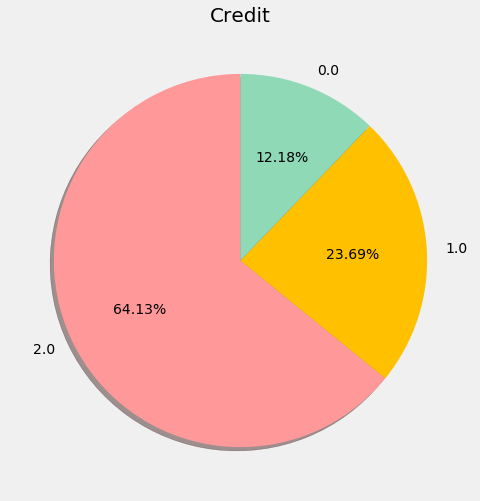

In [ ]:
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90, colors = colors)
plt.title('Credit', size=20)
plt.show()

In [ ]:

# Categorical 그래프 함수 정의
def cat_plot(column):

  # 등급에 따른 차이를 보기 위해 데이터 분류
  train_0 = train[train['credit']==0.0]
  train_1 = train[train['credit']==1.0]
  train_2 = train[train['credit']==2.0]

  f, ax = plt.subplots(1, 3, figsize=(16, 6))


  sns.countplot(x = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index)
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit = 0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit = 1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index)
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit = 2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

#### gender

- 남녀 비율 차이가 2배가 나타남

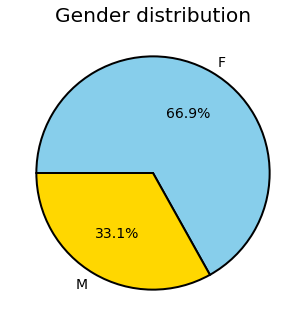

In [ ]:
train1= train.groupby('gender').count()['index']
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(train1, labels=train1.index,colors=['skyblue','gold'], startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linewidth':2})
plt.title('Gender distribution')
plt.show()

신용등급에 따라 성별 차이가 존재하는지 확인
- 모든 등급에서 남성보다 여성이 더 많음

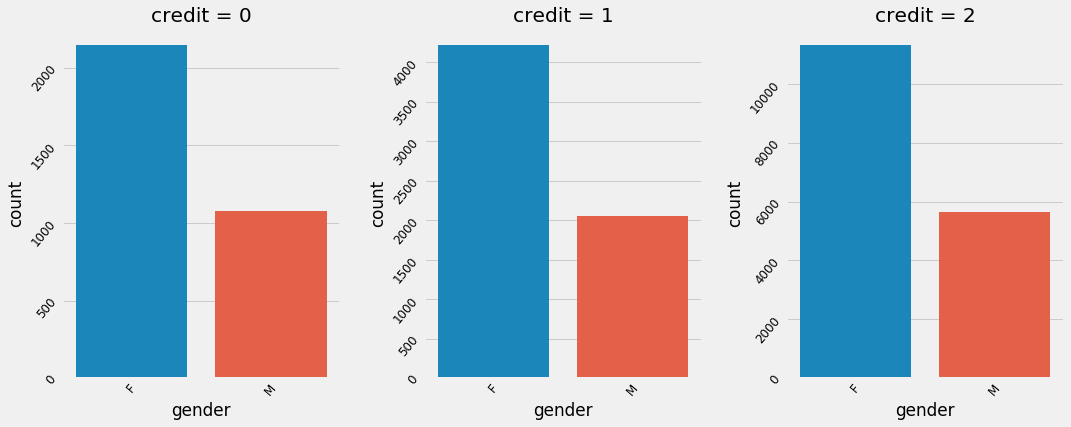

In [ ]:
cat_plot("gender")

#### car

- 차를 소유하지 않은 사람이 2배 더 많음

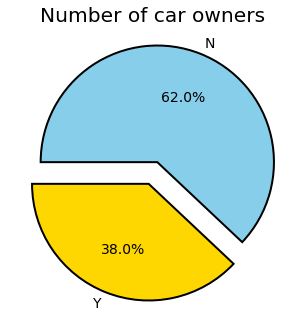

In [ ]:
train1= train.groupby('car').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(train1, labels=train1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linewidth':2})
plt.title('Number of car owners')
plt.show()


신용등급에 따라 차량 소유 차이가 존재하는지 확인
- 모든 등급에서 차를 보유하고 있지 않은 사람이 매우 많음

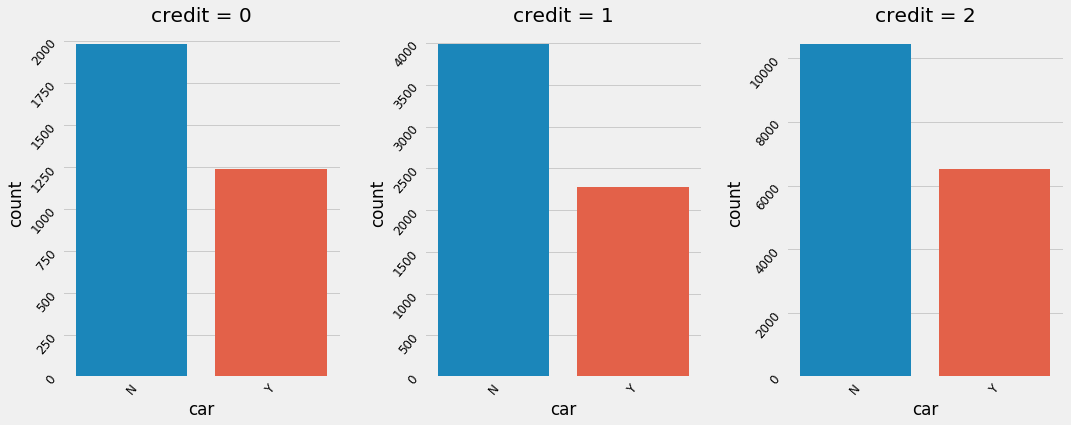

In [ ]:
cat_plot('car')

#### reality
신용등급에 따라 부동산 소유 차이가 존재하는지 확인
- 모든 등급에서 부동산을 소유한 사람들이 많음

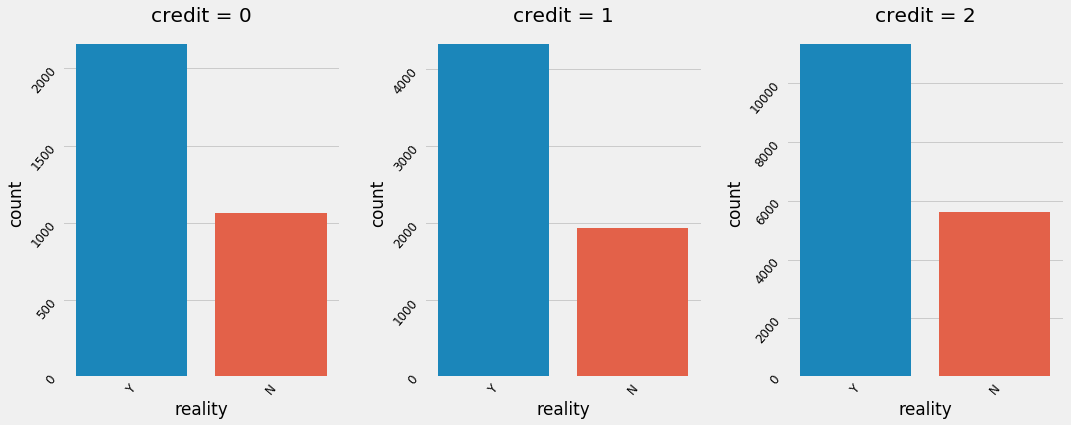

In [ ]:
cat_plot('reality')

#### income_type
신용등급에 따라 소득 분류 차이가 존재하는지 확인
- 높은 신용에서는 학생이 존재하지 않음

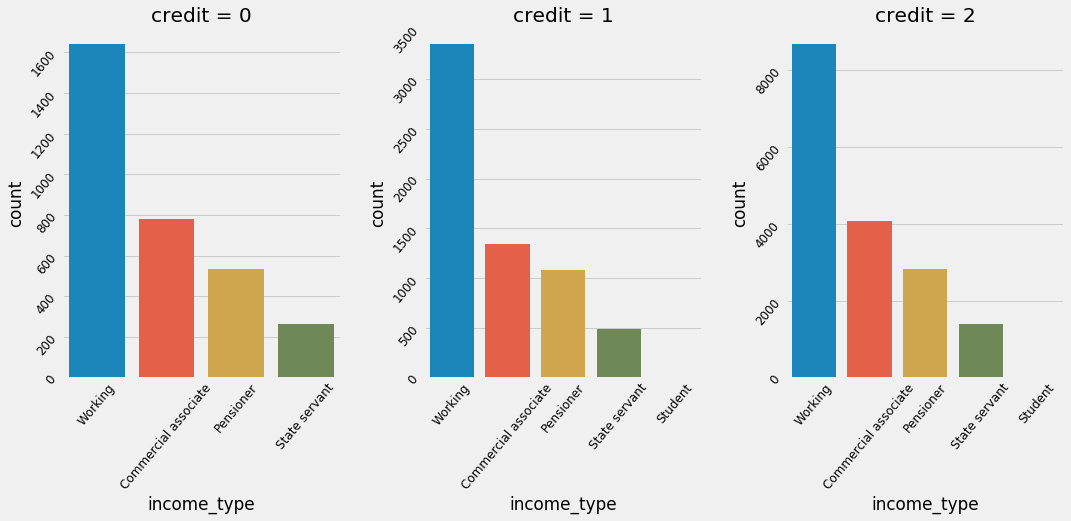

In [ ]:
cat_plot('income_type') 

#### edu_type
신용등급에 따라 교육 수준 차이가 존재하는지 확인
- 모든 등급에서 모든 등급에서 교육 수준의 순위가 같음

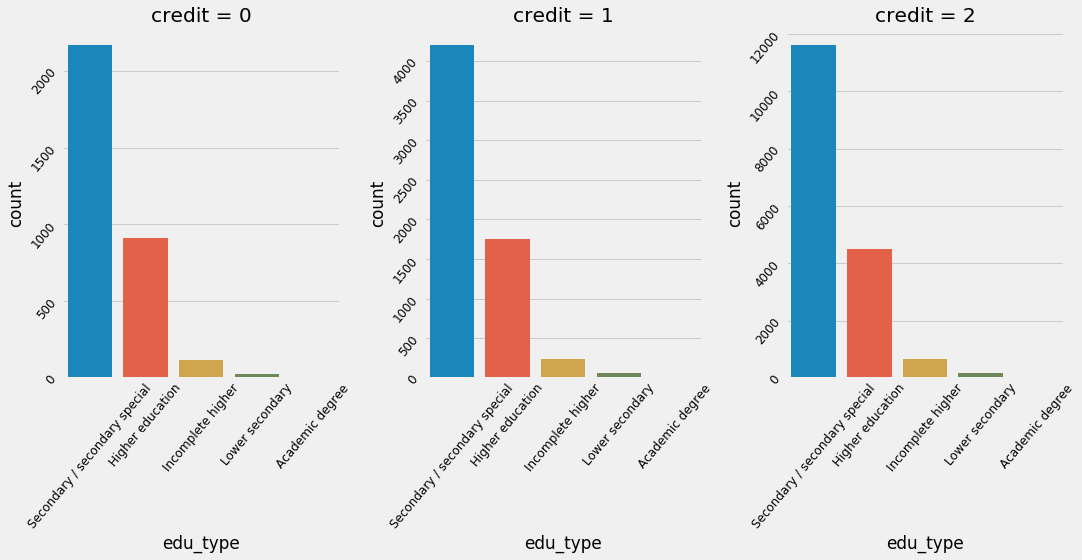

In [ ]:
cat_plot('edu_type')

#### family_type
신용등급에 따라 결혼 여부 차이가 존재하는지 확인
- 모든 등급에서 결혼을 한 사람들이 매우 많음

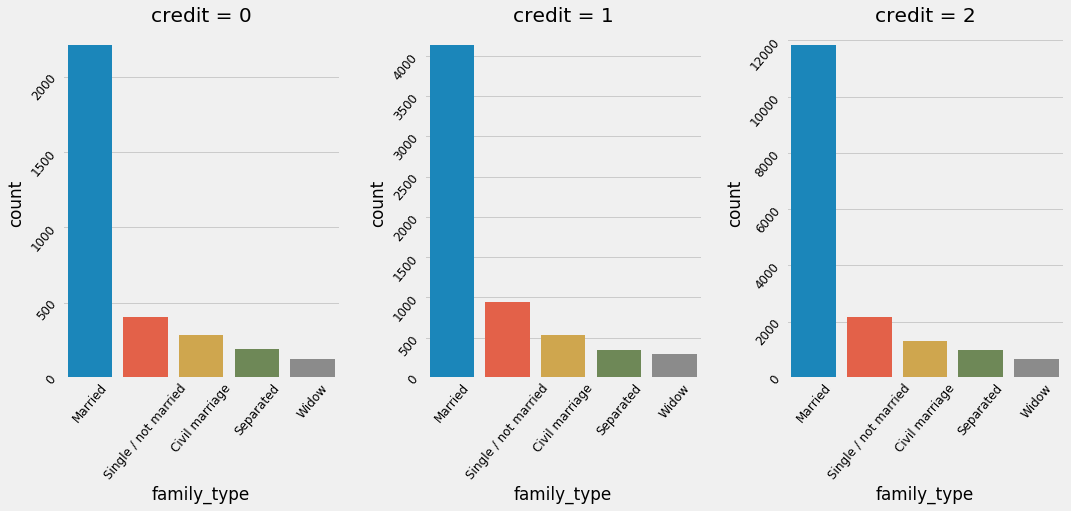

In [ ]:
cat_plot('family_type')

#### house_type
신용등급에 따라 생활방식 차이가 존재하는지 확인
- 모든 등급에서 교육 수준의 순위가 같음

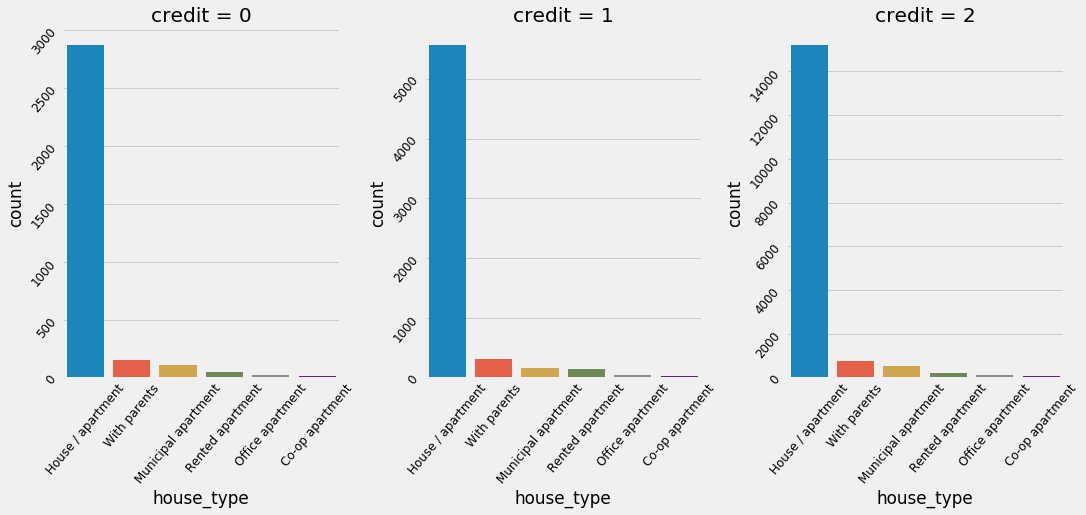

In [ ]:
cat_plot('house_type')

#### FLAG_MOBIL
신용등급에 따라 휴대폰 소지 차이가 존재하는지 확인
- 모든 사람들이 휴대폰을 소지함
- -> 해당 컬럼 삭제하기

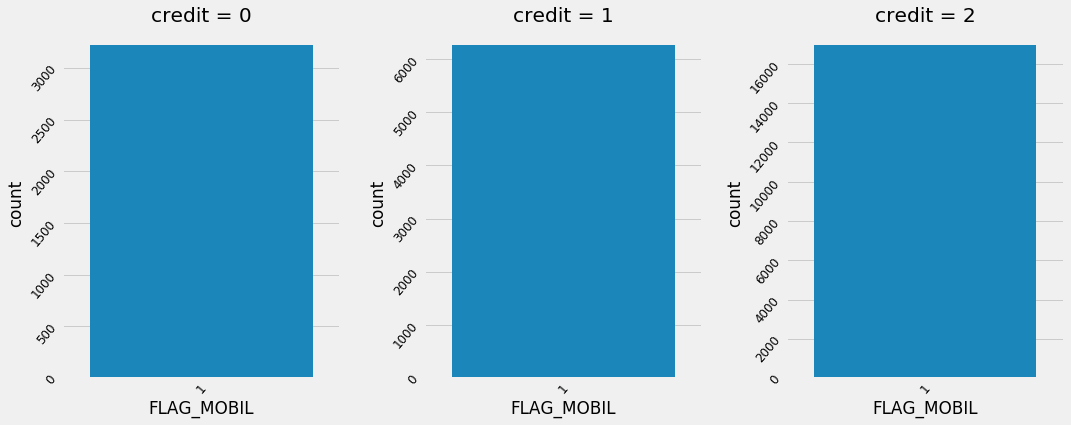

In [ ]:
cat_plot('FLAG_MOBIL')

#### work_phone
모든 신용등급에서 업무용 전화를 소유하고 있지 않는 사람들이 많음

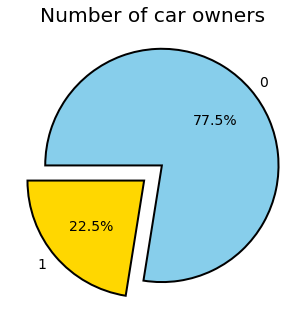

In [ ]:
train1= train.groupby('work_phone').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(train1, labels=train1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linewidth':2})
plt.title('Number of car owners')
plt.show()

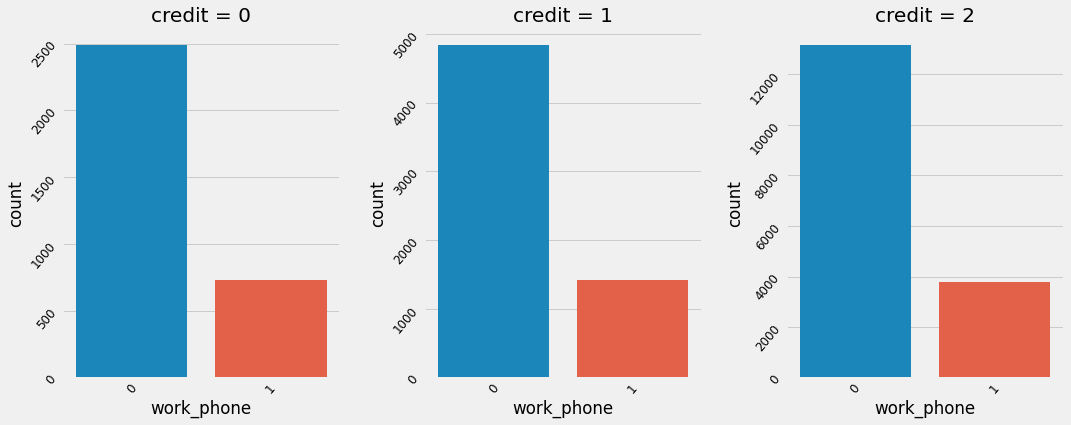

In [ ]:
cat_plot('work_phone')

#### phone
모든 신용등급에서 가정용 전화를 소유하고 있지 않는 사람들이 많음

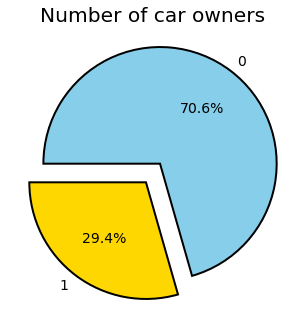

In [ ]:
train1= train.groupby('phone').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(train1, labels=train1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linewidth':2})
plt.title('Number of car owners')
plt.show()

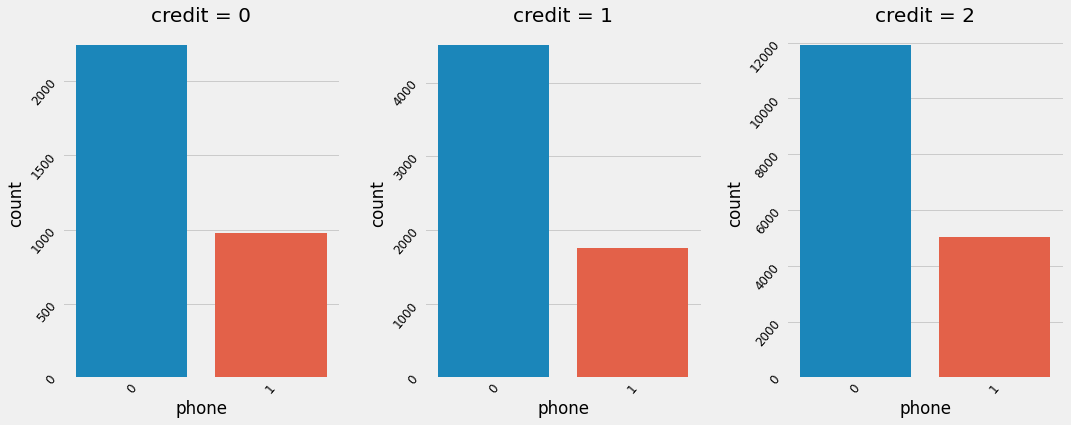

In [ ]:
cat_plot('phone')

#### email
모든 신용 등급에서 이메일을 소유한 사람들이 훨씬 많음

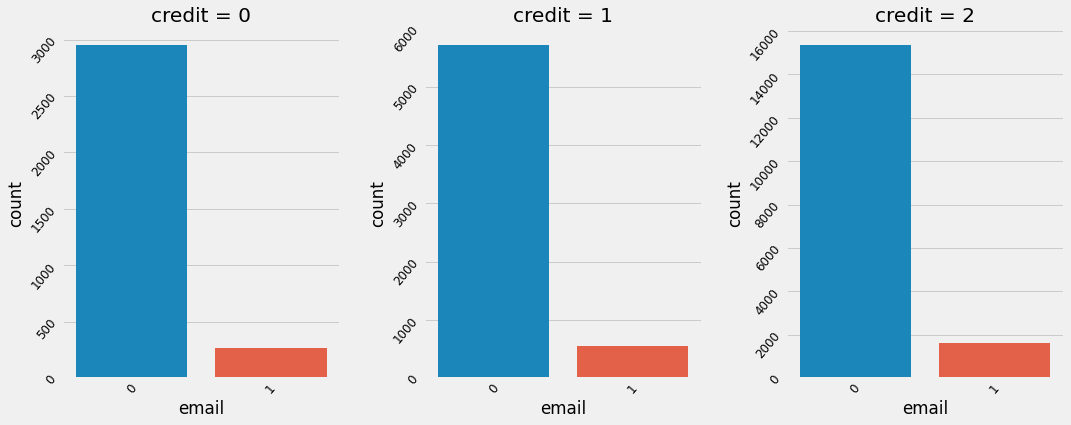

In [ ]:
cat_plot('email')

#### occyp_type

1) 해당 변수에 결측치 존재 확인

In [ ]:
# 결측치
print(len(train[train['occyp_type'].isnull()]))


8171


2) 신용등급에 따라 직업 유형 차이가 존재하는지 확인
- 등급별로 직업 유형의 순위 변동이 조금 존재

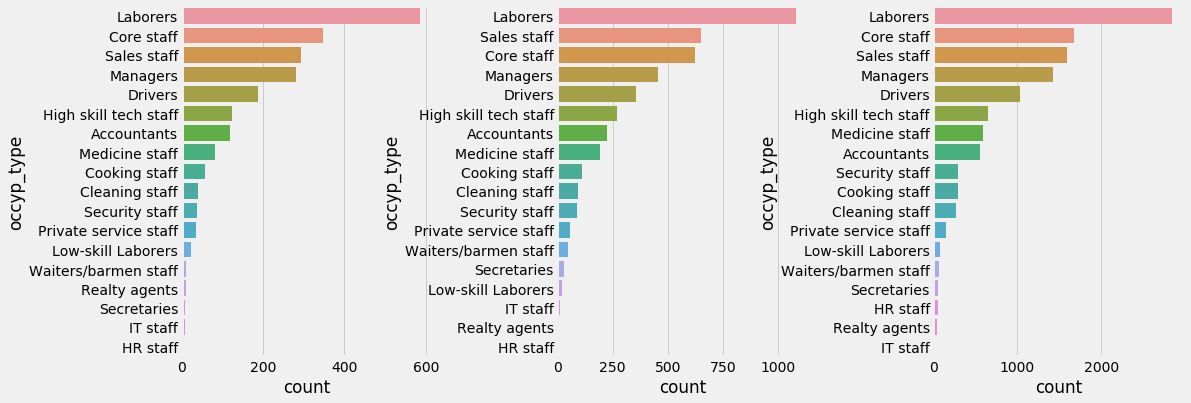

In [ ]:
train_0 = train[train.credit == 0]
train_1 = train[train.credit == 1]
train_2 = train[train.credit == 2]


f, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.countplot(y = 'occyp_type', data = train_0, order = train_0['occyp_type'].value_counts().index, ax=ax[0])
sns.countplot(y = 'occyp_type', data = train_1, order = train_1['occyp_type'].value_counts().index, ax=ax[1])
sns.countplot(y = 'occyp_type', data = train_2, order = train_2['occyp_type'].value_counts().index, ax=ax[2])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

## 2) Numerical Variable EDA

In [ ]:
# Numerical 그래프 함수 정의
def num_plot(column):
    
# 등급에 따른 차이를 보기 위해 데이터 분류
    train_0 = train[train['credit']==0.0]
    train_1 = train[train['credit']==1.0]
    train_2 = train[train['credit']==2.0]


    fig, axes = plt.subplots(1, 3, figsize=(16, 6))


    sns.distplot(train_0[column],
                ax = axes[0])
    axes[0].tick_params(labelsize=10)
    axes[0].set_title('credit = 0')
    axes[0].set_ylabel('density')

    sns.distplot(train_1[column],
                ax = axes[1])
    axes[1].tick_params(labelsize=10)
    axes[1].set_title('credit = 1')
    axes[1].set_ylabel('density')

    sns.distplot(train_2[column],
                ax = axes[2])
    axes[2].tick_params(labelsize=10)
    axes[2].set_title('credit = 2')
    axes[2].set_ylabel('density')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

#### child_num

- child_num이 7, 14, 19로 매우 큰 값인 경우 존재
    - 이상치일 가능성이 있음

In [ ]:
train['child_num'].describe()

count    26457.000000
mean         0.428658
std          0.747326
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: child_num, dtype: float64

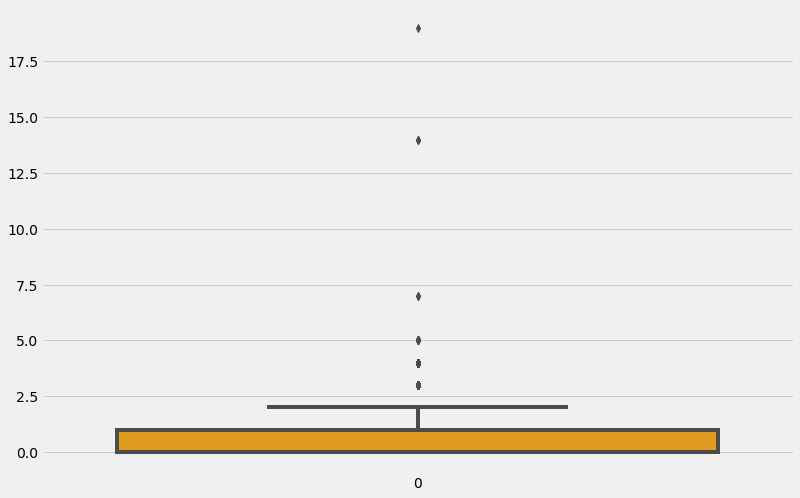

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data= train['child_num'], color = 'orange')
plt.show()

2) 신용등급에 따라 자녀수 차이가 존재하는지 확인
- 등급별 차이가 거의 없음

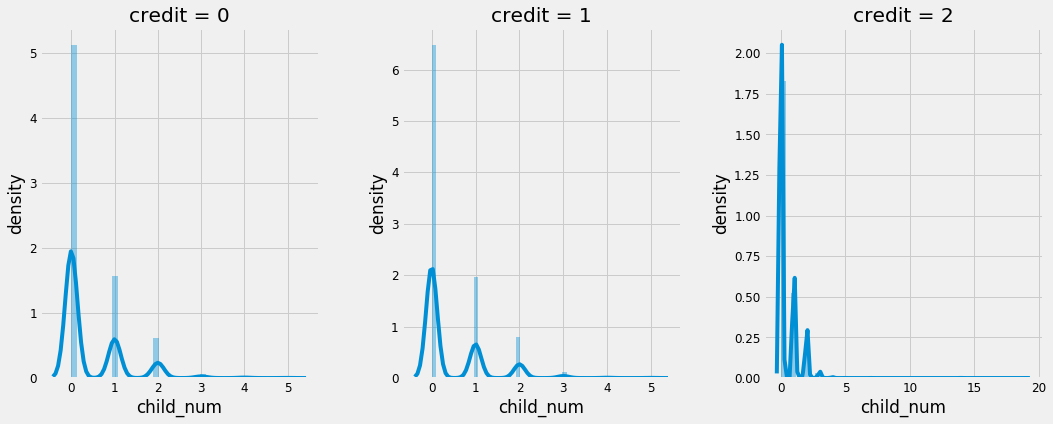

In [ ]:
num_plot("child_num")

- child_num>=6 인 경우 신용등급은 항상 2이다. 

In [ ]:
train[train.child_num>=6].loc[:,['child_num','credit']]  

,child_num,credit
8462,14,2.0
9021,14,2.0
10731,19,2.0
25313,7,2.0
25390,14,2.0
25638,7,2.0


#### income_total
신용등급에 따라 연간 소득 차이가 존재하는지 확인

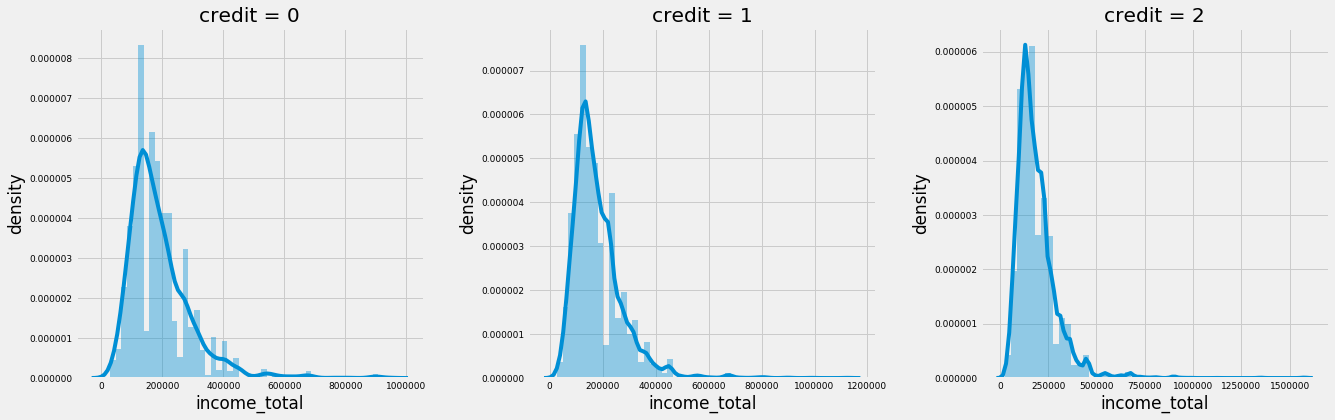

In [ ]:
num_plot("income_total")

#### DAYS_BIRTH -> age
    : DAYS_BIRTH는 출생일을 의미.
    태어난 날을 기준으로 살아온 날을 음수로 표기 ex) 5000일 전에 태어난 경우 -5000으로 표기    
    
- 1) DAYS_BIRTH를 나이로 변환하여 age 변수 생성
- 2) age에 따른 EDA확인

In [ ]:
# DAYS_BIRTH는 출생일을 의미. 해당 값을 나이로 변환

train['age'] = abs(train.DAYS_BIRTH//365)
train = train.astype({'age': 'int'})

#train['age'].describe()

test['age'] = abs(test.DAYS_BIRTH//365)
test = test.astype({'age': 'int'})

 30, 40, 50대가 주를 이루고 있음

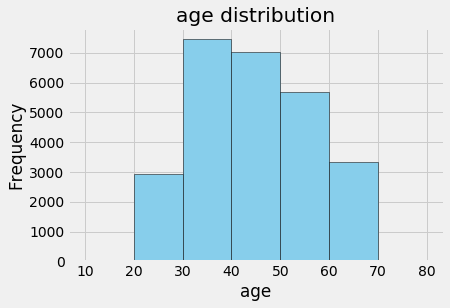

In [ ]:
train['age'].plot.hist(bins=range(10,81,10),color='skyblue', edgecolor='k')
plt.xlabel('age')
plt.title('age distribution')
plt.show()

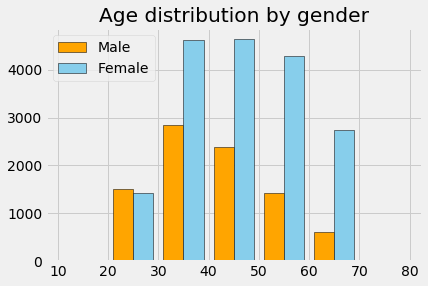

In [ ]:
# 성별에 따른 분포
sex = train.groupby('gender')
M_group= sex.get_group('M')
F_group= sex.get_group('F')
M = M_group['age']
F = F_group['age']

plt.hist([M,F], bins=range(10,81,10), label=['Male', 'Female'],edgecolor='k', color=['orange','skyblue'])
plt.legend(loc='upper left')
plt.title('Age distribution by gender')
plt.show()

신용등급에 따라 연령대 차이가 존재하는지 확인
- 등급별 차이가 거의 없음. 모든 등급에서 20~30대 비율이 낮음

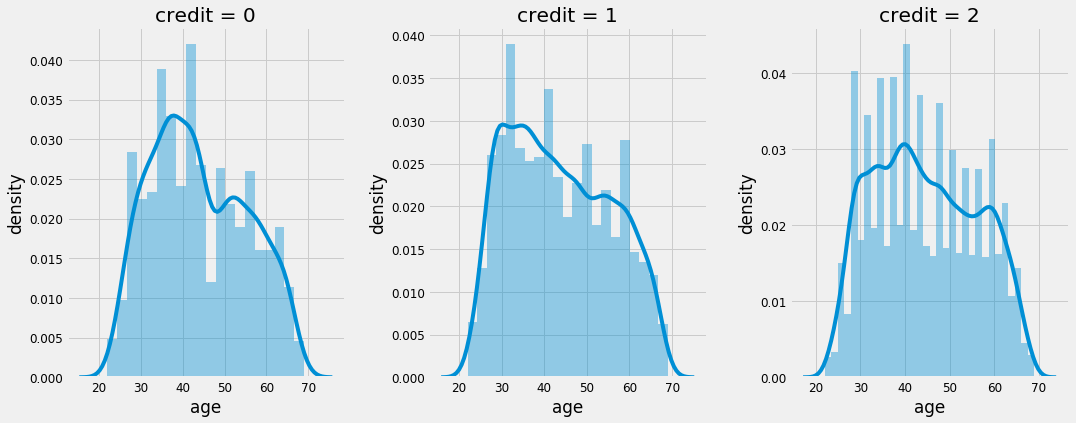

In [ ]:
num_plot("age")

#### DAYS_EMPLOYED
    : 업무 시작일
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미 
    양수 값은 고용되지 않은 상태를 의미함
    
- 무직인 사람의 수가 많은 것을 확인
    

In [ ]:
# DAYS_EMPLOYED가 양수일 때에는 무직을 의미하므로 0으로 대체
train['DAYS_EMPLOYED']= train['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
test['DAYS_EMPLOYED']= test['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)

# 음수를 양수로 대체
train['DAYS_EMPLOYED']=np.abs(train['DAYS_EMPLOYED'])
test['DAYS_EMPLOYED']=np.abs(test['DAYS_EMPLOYED'])

In [ ]:
len(train[train.DAYS_EMPLOYED==0])

4438

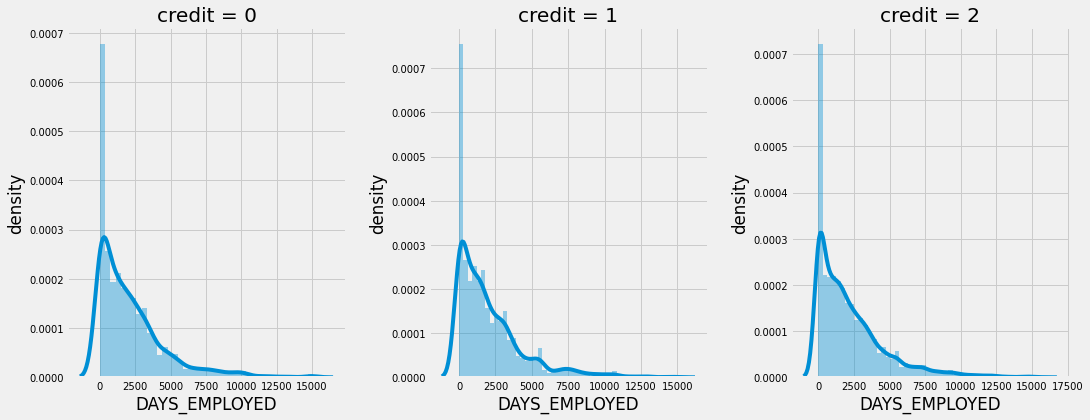

In [ ]:
num_plot("DAYS_EMPLOYED")

- employed_y : 근속 연수

신용등급 별 근속연수의 차이가 거의 없음


In [ ]:
# 근속 연수
train['employed_y'] = abs(train['DAYS_EMPLOYED'])//365
train = train.astype({'employed_y': 'int'})
test['employed_y'] = abs(test['DAYS_EMPLOYED'])//365
test = test.astype({'employed_y': 'int'})

train['employed_y'].describe() 

- 데이터에서 무직인 경우를 제외하고, 근속 연수 확인

모든 등급에서 근속연수의 차이가 없음

근속연수가 0인 경우가 매우 많고, 대부분 5년이하임


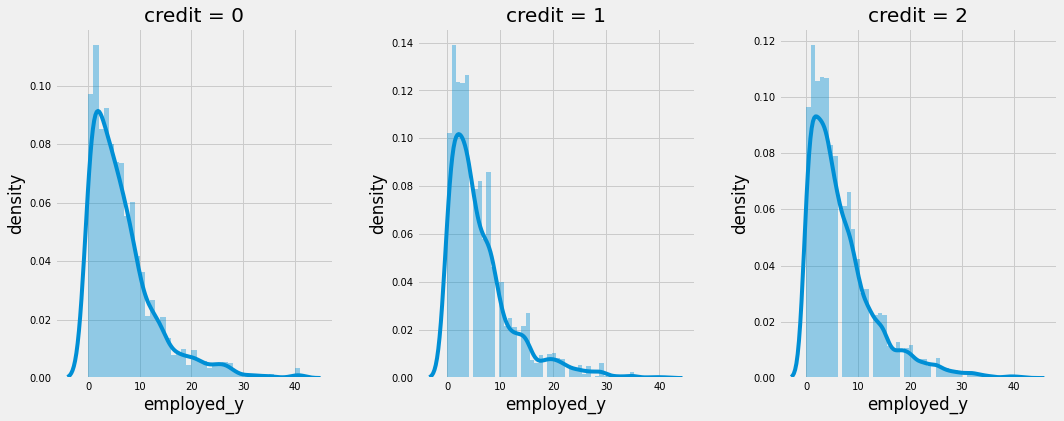

In [ ]:
train_origin = train.copy()

train.loc[(train.employed_y==0) & (train.DAYS_EMPLOYED ==0),'employed_y' ] = -1
index1 = train[(train.employed_y==-1) ].index
train = train.drop(index1)

num_plot("employed_y")

In [ ]:
train = train_origin.copy()

#### family_size

1) family_size가 지나치게 큰 경우가 존재함
- 이상치가 있을 수 있다고 판단

In [ ]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

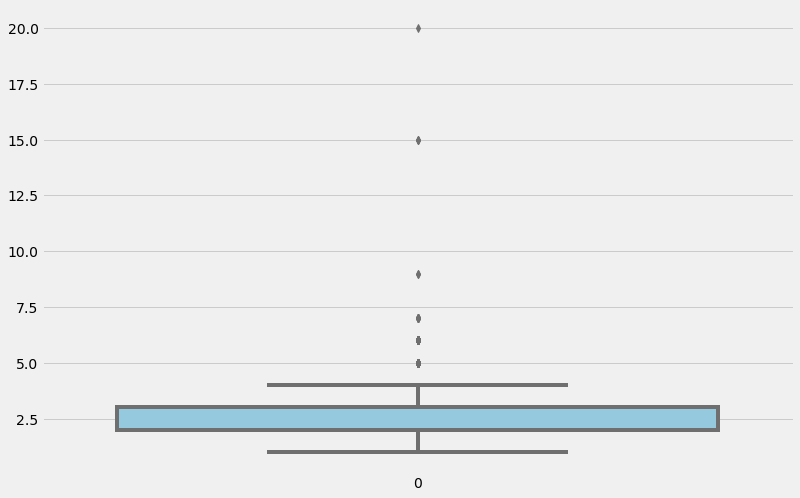

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data= train['family_size'] , color = 'skyblue')
plt.show()

2) 신용등급에 따라 가족 수 차이가 존재하는지 확인

- 보통 가족 수가 2명인 사람들이 많음
- 결혼한 사람들이 많았던 결과와 연관되는 결과
- 2등급에서는 1,2에 비해 왼쪽으로 치우진 그래프가 나옴

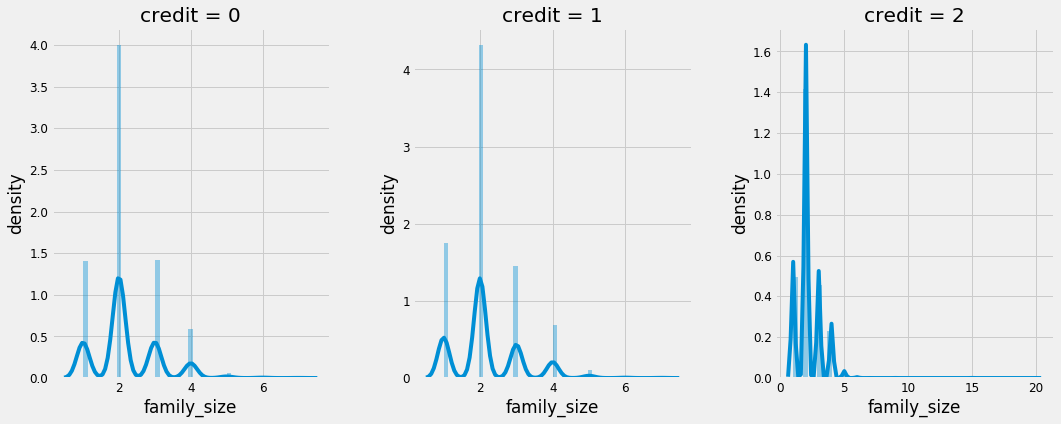

In [ ]:
num_plot("family_size")

- family_size가 8명 이상이면 신용등급은 항상 2이다.

In [ ]:
train[train.family_size>=8].loc[:,['family_size','credit']]  

,family_size,credit
8462,15.0,2.0
9021,15.0,2.0
10731,20.0,2.0
25313,9.0,2.0
25390,15.0,2.0
25638,9.0,2.0


#### begin_month
신용등급에 따라 카드 발급 기간 차이가 존재하는지 확인
- 대부분 카드를 발급 받은지 10달 이하인 사람들이 많음

In [ ]:
train['begin_month'] = abs(train['begin_month'])
train = train.astype({'begin_month': 'int'})
train['begin_month'].head()

0     6
1     5
2    22
3    37
4    26
Name: begin_month, dtype: int32

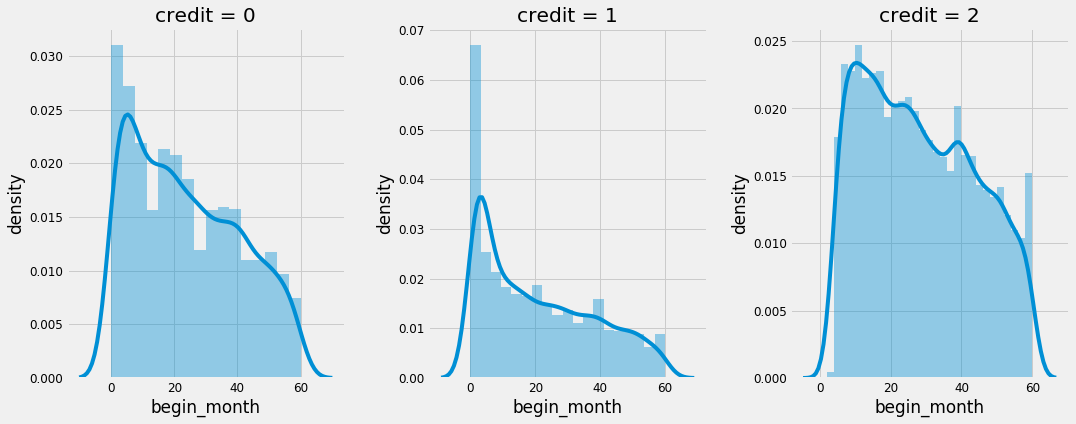

In [ ]:
num_plot("begin_month")

# 3. Data Preprocessing
탐색적 데이터 분석(EDA)를 기반으로 전처리 수행

#### 1) 결측치 확인 및 처리
occyp_type 직업 유형에서 null 값이 있는 것을 확인

In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
age                 0
employed_y          0
dtype: int64

In [ ]:
test.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
age                 0
employed_y          0
dtype: int64

occyp_type 변수의 null 값 대체

- DAYS_EMPLOYED 가 양수인 경우(=0), 무직을 의미하므로 No_job으로 대체
- 이외 값은 제거


- DAYS_EMPLOYED: 업무 시작일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미 양수 값은 고용되지 않은 상태를 의미함

In [ ]:
# 결측치
print(len(train[train['occyp_type'].isnull()]))
# 결측치 중 무직인 경우
print(len(train[train.DAYS_EMPLOYED ==0]))  # DAYS_EMPLOYED 가 양수인 경우 =0으로 대체되어있음

# 결측치
print(len(test[test['occyp_type'].isnull()]))
# 결측치 중 무직인 경우
print(len(test[test.DAYS_EMPLOYED ==0]))  # DAYS_EMPLOYED 가 양수인 경우 =0으로 대체되어있음

8171
4438
3152
1697


In [ ]:
# 결측치 제거
# occyp_type이 null이면서 취직을 한 경우 'NaN'값으로 대체
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

# 무직인 경우 NO job으로 대체
# occyp_type이 nan이면서 취직을 하지 않은 경우
train.loc[(train['DAYS_EMPLOYED'] == 0) & (train['occyp_type'] == 'NaN'), 'occyp_type'] = 'No_job'
test.loc[(train['DAYS_EMPLOYED'] == 0) & (test['occyp_type'] == 'NaN'), 'occyp_type'] = 'No_job'

print(train['occyp_type'].value_counts(), '\n\n')

Laborers                 4512
No_job                   4438
NaN                      3733
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64 




No_job과 NaN 비중이 높고, 신용등급 별 직업유형 차이가 있음을 알 수 있음

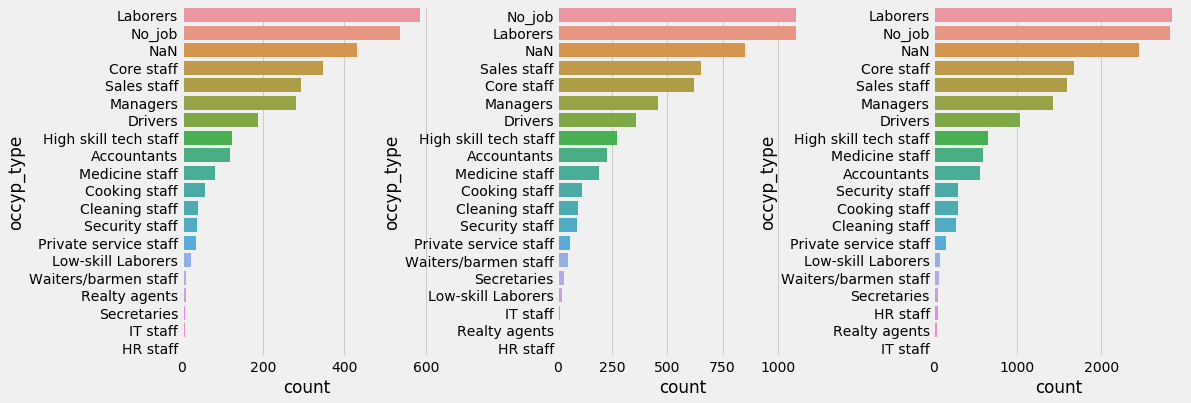

In [ ]:
train_0 = train[train.credit == 0]
train_1 = train[train.credit == 1]
train_2 = train[train.credit == 2]


f, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.countplot(y = 'occyp_type', data = train_0, order = train_0['occyp_type'].value_counts().index, ax=ax[0])
sns.countplot(y = 'occyp_type', data = train_1, order = train_1['occyp_type'].value_counts().index, ax=ax[1])
sns.countplot(y = 'occyp_type', data = train_2, order = train_2['occyp_type'].value_counts().index, ax=ax[2])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

#### 2) 중복 값 확인 및 처리
- 중복된 사용자 존재
  - begin_month와 credit을 제외하고 모든 컬럼의 값이 같은 경우 존재 
  -  한 명의 사용자가 여러 개의 카드를 만든 경우
- ID 변수를 추가해서 중복 사용자 처리

In [ ]:
# begin_month를 제외하고 같은 값을 가지는 행

same_user = train.copy()
same_user = same_user.drop(['index','begin_month'], axis=1)
len(same_user[same_user.duplicated()])

14358

In [ ]:
# begin_month와 credit을 제외하고 같은 값을 가지는 행

same_user = same_user.drop(['credit'], axis=1)
len(same_user[same_user.duplicated()])

17698

- ID 변수 추가
  - begin_month와 credit을 제외하고 같은 값을 가지는 경우 동일한 사용자로 판단

In [ ]:
for df in [train, test]:
  df['ID'] = \
  df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
  df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
  df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
  df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
  df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
  df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
  df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
  df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [ ]:
# ordinal_encoder 변환 후 정수 처리

encoder = OrdinalEncoder('ID')
train['ID'] = encoder.fit_transform(train['ID'])
test['ID'] = encoder.transform(test['ID'])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,employed_y,ID
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,...,0,0,0,NaN,2.0,6,1.0,39,12,1
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,0,0,1,Laborers,3.0,5,1.0,32,4,2
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,...,0,1,0,Managers,2.0,22,2.0,53,12,3
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,1,0,Sales staff,2.0,37,0.0,42,5,4
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,...,0,0,0,Managers,2.0,26,2.0,42,5,5


In [ ]:
train.shape

(26457, 23)

In [ ]:
len(train.ID.unique())

8759

#### 3) 이상치 확인 및 처리


- 이상치로 판단됐던 데이터: child_num이 6이상 이고, family_size가 7보다 큰 데이터
- family_size >  7 인 데이터 제거

In [ ]:
train[(train['family_size'] > 7)].loc[:,['family_size', 'child_num']]

,family_size,child_num
8462,15.0,14
9021,15.0,14
10731,20.0,19
25313,9.0,7
25390,15.0,14
25638,9.0,7


In [ ]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

# 4. Feature engineering

탐색적 데이터 분석(EDA)를 기반으로 Feature engineering 수행






#### 1) 음수 feature 양수로 바꾸기

In [ ]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

#### 2) 의미없는 변수 제거

- index 제거
- FLAG_MOBIL 컬럼 삭제
모든 사람들이 휴대폰을 소지함. 의미있는 feature가 아님

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

#### 3) Creating feature

위에서 생성된 파생변수
- age : 나이
- employed_y : 근속연수

- employed_m: 고용된 달 
- employed_w: 고용된 주.고용연도의 n주차

In [ ]:
train['employed_m'] = np.floor(train['DAYS_EMPLOYED'] / 30) - ((np.floor(train['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
test['employed_m'] = np.floor(test['DAYS_EMPLOYED'] / 30) - ((np.floor(test['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)

train['employed_w'] = np.floor(train['DAYS_EMPLOYED'] / 7) - ((np.floor(train['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)
test['employed_w'] = np.floor(test['DAYS_EMPLOYED'] / 7) - ((np.floor(test['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

- income_ability: 소득/(살아온 일수+ 근무일수)
- income_mean: 소득 / 가족 수 = income_total/family_size

In [ ]:
train['income_ability'] = train['income_total'] / (train['DAYS_BIRTH'] + train['DAYS_EMPLOYED'])
test['income_ability'] = test['income_total'] / (test['DAYS_BIRTH'] + test['DAYS_EMPLOYED'])

 #income_mean: 소득/ 가족 수
train['income_mean'] = train['income_total'] / train['family_size']
test['income_mean'] = test['income_total'] / test['family_size']

#### 4) Scaling

In [ ]:
train.dtypes

gender             object
car                object
reality            object
child_num           int64
income_total      float64
income_type        object
edu_type           object
family_type        object
house_type         object
DAYS_BIRTH          int64
DAYS_EMPLOYED       int64
work_phone          int64
phone               int64
email               int64
occyp_type         object
family_size       float64
begin_month       float64
credit            float64
age                 int32
employed_y          int32
ID                  int64
income_mean       float64
employed_m        float64
employed_w        float64
income_ability    float64
dtype: object

In [ ]:
# Numeric, Category 컬럼 분류

numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

numerical_feats

Number of Numerical features:  16
Number of Categorical features:  8


['child_num',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'age',
 'employed_y',
 'ID',
 'income_mean',
 'employed_m',
 'employed_w',
 'income_ability']

In [ ]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

4-1) income_total을 Log Scale

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

4-2) StandardScale
- 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [ ]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

#### 5) Encoding
- 카테고리 변수 OrdinalEncoder 변환
- ID는 변환 후 정수 처리

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

#### 6) Feature Selection
- 다중공선성 확인 후 컬럼 삭제하고, 필요한 컬럼만 사용


- (1)  상관계수를 통한 다중공선성 확인

In [ ]:
corr_matrix = train.corr()
corr_matrix

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,family_size,begin_month,credit,age,employed_y,ID,income_mean,employed_m,employed_w,income_ability
gender,1.000000,0.362149,-0.049110,0.077570,0.231543,-0.155328,0.018326,-0.119878,0.078605,-0.201303,...,0.112030,-0.007832,0.001506,-0.201082,-0.039349,0.019663,0.065163,0.090841,0.092818,0.269109
car,0.362149,1.000000,-0.016768,0.104004,0.231414,-0.155155,-0.083437,-0.152459,0.028821,-0.157036,...,0.151576,0.029848,0.007724,-0.156602,-0.001126,-0.006326,0.060386,0.104026,0.072504,0.241073
reality,-0.049110,-0.016768,1.000000,-0.000720,0.036171,0.072731,-0.001538,0.016139,-0.070198,0.130203,...,-0.007629,-0.003862,-0.009386,0.129623,-0.036206,-0.000716,0.039328,-0.045068,-0.051851,-0.016882
child_num,0.077570,0.104004,-0.000720,1.000000,0.037636,-0.178348,-0.036313,-0.187131,0.022665,-0.343928,...,0.886135,0.007353,0.001630,-0.343880,0.039223,0.004253,-0.346738,0.103223,0.115439,0.123385
income_total,0.231543,0.231414,0.036171,0.037636,1.000000,-0.222336,-0.174083,0.004876,0.036197,-0.105348,...,0.023041,0.023692,0.005518,-0.105096,0.095325,-0.052768,0.673461,0.120561,0.108999,0.806575
income_type,-0.155328,-0.155155,0.072731,-0.178348,-0.222336,1.000000,0.067724,0.077333,-0.056623,0.532255,...,-0.170099,0.000581,-0.005021,0.532116,-0.253875,-0.010149,-0.064760,-0.460483,-0.407876,-0.288579
edu_type,0.018326,-0.083437,-0.001538,-0.036313,-0.174083,0.067724,1.000000,0.029220,-0.000380,0.065882,...,-0.035085,-0.009605,0.015484,0.066603,-0.036373,0.028613,-0.112812,-0.032569,-0.041520,-0.167833
family_type,-0.119878,-0.152459,0.016139,-0.187131,0.004876,0.077333,0.029220,1.000000,0.023680,0.071188,...,-0.593353,-0.042364,-0.015607,0.071008,-0.059433,0.008161,0.490961,-0.039566,-0.070812,0.004084
house_type,0.078605,0.028821,-0.070198,0.022665,0.036197,-0.056623,-0.000380,0.023680,1.000000,-0.129687,...,0.007124,-0.019399,-0.016084,-0.129486,-0.013111,-0.007583,0.034519,0.050825,0.039471,0.082335
DAYS_BIRTH,-0.201303,-0.157036,0.130203,-0.343928,-0.105348,0.532255,0.065882,0.071188,-0.129687,1.000000,...,-0.303883,0.057237,0.025212,0.999692,-0.002727,-0.004678,0.072727,-0.350682,-0.307209,-0.439668


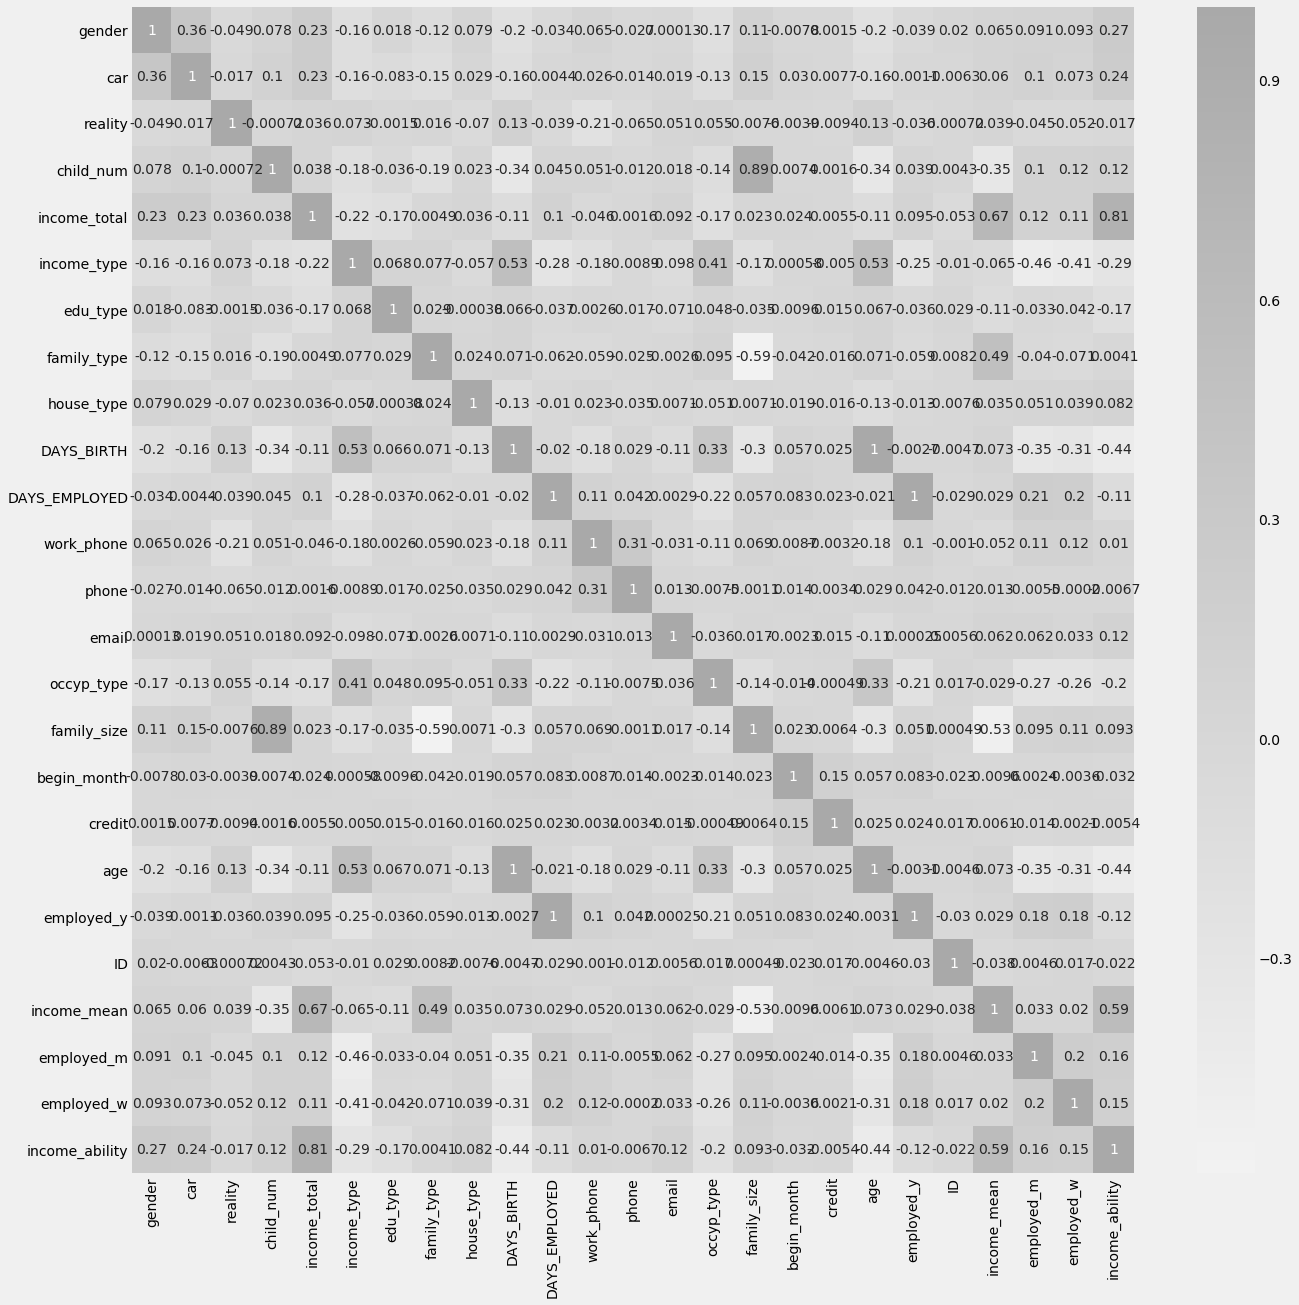

In [ ]:
# heatmap. 상관행렬 시각화

fig = plt.figure(figsize=(20,20)) ## 캔버스 생성
cmap = sns.light_palette("darkgray", as_cmap = True)  
sns.heatmap(train.corr(), annot = True, cmap = cmap)
plt.show()

0.5가 넘어가는 변수들간의 상관관계가 빈출되는 것은 충분히 다중공선성 발생을 의심할 수 있다.

- (2) VIF를 통한 다중공선성 확인

VIF가 10이 넘으면 다중공선성이 있다고 판단.
vif가 높은 변수가 하나씩 줄어들면 다른 변수들의 vif에도 영향을 미친다. 


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
vif["features"] = train.columns
vif

,VIF Factor,features
0,11.266425,gender
1,11.086774,car
2,14.668442,reality
3,28.801492,child_num
4,84.751081,income_total
5,11.737405,income_type
6,11.763258,edu_type
7,26.238032,family_type
8,14.112074,house_type
9,1631.927276,DAYS_BIRTH


- 다중공선성 문제를 발생시키는 변수 삭제

In [ ]:
# 다중공선성 문제를 발생시키는 변수 삭제
# 변수들을 하나씩 제거하면서 다중공선성을 확인한 결과, 4개의 컬럼 삭제 후 다중공선성 문제가 해결됌.

cols = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'income_total', 'child_num']  #family_size
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
vif["features"] = train.columns
vif

,VIF Factor,features
0,10.541730,gender
1,9.957072,car
2,11.518680,reality
3,10.211752,income_type
4,10.321028,edu_type
5,5.492450,family_type
6,11.646447,house_type
7,1.212193,work_phone
8,1.120416,phone
9,1.032641,email


# 4. Modeling

## 1) Modeling with Pycaret


In [ ]:
clf = setup(data=train, target='credit', train_size=0.8)

,Description,Value
0,session_id,6794
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26451, 21)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x00000241AB1A2598>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

데이터에 적합한 모델 찾기

In [ ]:
# 데이터에 적합한 모델 찾기

#svm, ridge는 predict_proba 미지원으로 제외
best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
catboost,CatBoost Classifier,0.7035,0.7126,0.4483,0.6916,0.6401,0.2716,0.3355,0.7594,17.2100
lightgbm,Light Gradient Boosting Machine,0.6993,0.7097,0.4304,0.6926,0.6257,0.2443,0.3223,0.7606,1.0600
gbc,Gradient Boosting Classifier,0.6932,0.6559,0.4109,0.6604,0.6084,0.2130,0.3031,0.7946,14.8060
lda,Linear Discriminant Analysis,0.6435,0.6068,0.3376,0.5367,0.5104,0.0124,0.0505,0.8625,0.4180
lr,Logistic Regression,0.6422,0.6065,0.3333,0.4125,0.5023,0.0000,0.0000,0.8655,1.3040
nb,Naive Bayes,0.6490,0.6041,0.3435,0.5871,0.5192,0.0304,0.1065,0.8670,0.1140
rf,Random Forest Classifier,0.7013,0.7485,0.5417,0.6801,0.6854,0.3750,0.3808,0.9872,3.8740
ada,Ada Boost Classifier,0.6909,0.6265,0.4055,0.6338,0.6026,0.2008,0.2969,1.0783,1.2200
et,Extra Trees Classifier,0.6733,0.7099,0.5188,0.6520,0.6583,0.3191,0.3238,2.4770,4.1280
knn,K Neighbors Classifier,0.6169,0.6631,0.4702,0.5979,0.6052,0.2185,0.2202,3.8550,1.5980


In [ ]:
best5

 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=2017, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
         

- best5 모델을 블렌딩
     - 상위 2개의 단일 모델보다 좋지 않은 결과가 나옴

In [ ]:
blended = blend_models(estimator_list = best5, fold = 5, optimize = 'logloss')
pred_holdout = predict_model(blended)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6997,0.6978,0.4177,0.7342,0.6158,0.2261,0.3289,0.7817
1,0.6898,0.6934,0.4039,0.6785,0.6007,0.1951,0.2936,0.7911
2,0.6927,0.6861,0.4083,0.7385,0.6057,0.2069,0.3023,0.7928
3,0.6964,0.7015,0.4131,0.6516,0.6113,0.2205,0.3157,0.7847
4,0.6948,0.6979,0.4117,0.6641,0.6095,0.2173,0.3094,0.7855
Mean,0.6947,0.6954,0.4109,0.6934,0.6086,0.2132,0.3100,0.7872
SD,0.0034,0.0053,0.0046,0.0361,0.0051,0.0110,0.0120,0.0042


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Voting Classifier,0.6924,0.6990,0.4131,0.7460,0.6065,0.2144,0.3151,0.7900


In [ ]:
save_model(blended,'pycaret_blended')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=['index'],
                                       ml_usecase='classification',
                                       numerical_features=[], target='credit',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeri...
                                                                           store_covariance=False,
                                                                           tol=0.0001)),
                                               ('lr',
                                

In [ ]:
blended

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x00000241BA9C8240>),
                             ('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, o...
                                                         store_covariance=False,
                                                     

- custom_model 생성
  - 상위 7개의 모델에서 lr을 제외하고 블렌딩
  - 상위 2개의 단일 모델보다 좋지 않은 결과가 나옴

In [ ]:
# 커스텀모델 생성
# rf가 logloss는 나쁘지만, accuracy와 auc가 높은 값을 보임
# accuracy가 nb와 rf보다 낮은 lr을 제외하고, rf를 추가하여 커스텀 모델 생성

custom_model = compare_models(fold = 5, sort = 'logloss', n_select = 6, include=['catboost','lightgbm','gbc', 'lda', 'nb', 'rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
catboost,CatBoost Classifier,0.7035,0.7126,0.4483,0.6916,0.6401,0.2716,0.3355,0.7594,18.7020
lightgbm,Light Gradient Boosting Machine,0.6993,0.7097,0.4304,0.6926,0.6257,0.2443,0.3223,0.7606,1.4760
gbc,Gradient Boosting Classifier,0.6932,0.6559,0.4109,0.6604,0.6084,0.2130,0.3031,0.7946,11.6560
lda,Linear Discriminant Analysis,0.6435,0.6068,0.3376,0.5367,0.5104,0.0124,0.0505,0.8625,0.5400
nb,Naive Bayes,0.6490,0.6041,0.3435,0.5871,0.5192,0.0304,0.1065,0.8670,0.1760
rf,Random Forest Classifier,0.7013,0.7485,0.5417,0.6801,0.6854,0.3750,0.3808,0.9872,3.8320


In [ ]:
blended_custom = blend_models(estimator_list = custom_model, fold = 5, optimize = 'logloss')
pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6916,0.7029,0.4099,0.6742,0.6054,0.2120,0.3044,0.7876
1,0.6973,0.6944,0.4171,0.7096,0.6133,0.2263,0.3254,0.7872
2,0.6954,0.7095,0.4143,0.6740,0.6103,0.2211,0.3198,0.7843
3,0.6949,0.6982,0.4138,0.6713,0.6098,0.2206,0.3176,0.7889
4,0.6971,0.6984,0.4165,0.7484,0.6124,0.2259,0.3253,0.7875
Mean,0.6953,0.7007,0.4143,0.6955,0.6102,0.2212,0.3185,0.7871
SD,0.0020,0.0052,0.0025,0.0300,0.0028,0.0052,0.0077,0.0015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Voting Classifier,0.6946,0,0.4053,0.6163,0.6073,0.2013,0.2948,0


In [ ]:
blended_custom

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x00000241BC7070F0>),
                             ('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, o...
                                                     max_depth=None,
                                                     max_features

In [ ]:
save_model(blended_custom,'pycaret_blended_custom')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=['index'],
                                       ml_usecase='classification',
                                       numerical_features=[], target='credit',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeri...
                                                                       max_features='auto',
                                                                       max_leaf_nodes=None,
                                                                       max_samples=None,
 

- catboost 단일 모델 튜닝

In [ ]:
cell_start_time = time()
model_catboost = create_model('catboost', fold = 5)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7097,0.7138,0.4540,0.7058,0.6467,0.2861,0.3536,0.7512
1,0.7042,0.7165,0.4465,0.7032,0.6389,0.2680,0.3373,0.7585
2,0.6971,0.7033,0.4400,0.6804,0.6319,0.2545,0.3156,0.7726
3,0.7000,0.7138,0.4442,0.6725,0.6367,0.2664,0.3257,0.7597
4,0.7064,0.7158,0.4568,0.6963,0.6463,0.2830,0.3452,0.7550
Mean,0.7035,0.7126,0.4483,0.6916,0.6401,0.2716,0.3355,0.7594
SD,0.0045,0.0048,0.0062,0.0130,0.0057,0.0116,0.0136,0.0072


CELL RUN TIME :  123.55076146125793


In [ ]:
pred_catboost = predict_model(model_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,CatBoost Classifier,0.7026,0.7176,0.4508,0.6942,0.6395,0.2761,0.3421,0.7576


In [ ]:
# 모델 튜닝
cell_start_time = time()
tune_model_catboost = tune_model(model_catboost, fold=5, optimize = 'logloss', choose_better = True)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7062,0.7265,0.4573,0.6908,0.6468,0.2861,0.3465,0.7515
1,0.7082,0.7326,0.4651,0.6970,0.6519,0.2943,0.3532,0.7421
2,0.7038,0.7124,0.4585,0.6843,0.6464,0.2846,0.3398,0.7578
3,0.7035,0.7232,0.4500,0.6931,0.6404,0.2714,0.3380,0.7541
4,0.7057,0.7337,0.4534,0.6845,0.6444,0.2834,0.3449,0.7440
Mean,0.7055,0.7257,0.4569,0.6899,0.6460,0.2840,0.3445,0.7499
SD,0.0017,0.0077,0.0051,0.0049,0.0037,0.0074,0.0054,0.0059


CELL RUN TIME :  115.54248070716858


In [ ]:
save_model(model_catboost,'pycaret_model_catboost')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=['index'],
                                       ml_usecase='classification',
                                       numerical_features=[], target='credit',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeri...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='credit')),
                 ('fix_perfect', Remove_100(target='credit')),
                 ('clean_names', 

In [ ]:
save_model(tune_model_catboost,'pycaret_tune_model_catboost')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=['index'],
                                       ml_usecase='classification',
                                       numerical_features=[], target='credit',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeri...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='credit')),
                 ('fix_perfect', Remove_100(target='credit')),
                 ('clean_names', 

In [ ]:
final_model_catboost = finalize_model(model_catboost)


- LGBM 단일 모델 튜닝

In [ ]:
cell_start_time = time()
model_lightgbm = create_model('lightgbm', fold = 5)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)
model_lightgbm

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7059,0.7087,0.4423,0.7103,0.6367,0.2643,0.3436,0.7539
1,0.6953,0.7088,0.4201,0.6864,0.6165,0.2266,0.3087,0.7649
2,0.6997,0.7037,0.4315,0.7037,0.6264,0.2450,0.3235,0.7648
3,0.6969,0.7180,0.4266,0.6723,0.6224,0.2396,0.3150,0.7583
4,0.6988,0.7092,0.4317,0.6904,0.6263,0.2459,0.3209,0.7608
Mean,0.6993,0.7097,0.4304,0.6926,0.6257,0.2443,0.3223,0.7606
SD,0.0036,0.0046,0.0073,0.0134,0.0066,0.0122,0.0118,0.0042


CELL RUN TIME :  50.40455436706543


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2017, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 튜닝을 통한 성능향상
tune_model_lightgbm = tune_model(model_lightgbm, fold=5, optimize = 'AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7085,0.7159,0.4540,0.7022,0.6463,0.2858,0.3499,0.7522
1,0.7066,0.7268,0.4453,0.7008,0.6396,0.2712,0.3450,0.7494
2,0.7012,0.7127,0.4416,0.6961,0.6345,0.2617,0.3272,0.7641
3,0.7009,0.7159,0.4434,0.6676,0.6370,0.2708,0.3282,0.7577
4,0.7038,0.7166,0.4497,0.6962,0.6407,0.2730,0.3366,0.7549
Mean,0.7042,0.7176,0.4468,0.6926,0.6396,0.2725,0.3374,0.7557
SD,0.0030,0.0048,0.0045,0.0127,0.0040,0.0077,0.0090,0.0050


In [ ]:
tune_model_lightgbm

LGBMClassifier(bagging_fraction=1.0, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=91, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=280, n_jobs=-1, num_leaves=256, objective=None,
               random_state=2017, reg_alpha=0.01, reg_lambda=0.4, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
save_model(model_lightgbm,'pycaret_model_lightgbm')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=['index'],
                                       ml_usecase='classification',
                                       numerical_features=[], target='credit',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeri...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20,

In [ ]:
save_model(tune_model_lightgbm,'pycaret_tune_model_lightgbm')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=['index'],
                                       ml_usecase='classification',
                                       numerical_features=[], target='credit',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeri...
                                 colsample_bytree=1.0, feature_fraction=0.7,
                                 importance_type='split', learning_rate=0.1,
                                 max_depth=-1, min_child_samples=91,
                                 min_child_weight=0

- best 2모델 블렌딩: catboost, lightgbm 블렌딩
     - catboost 단일 모델보다 좋지 않은 결과

In [ ]:
best2 = compare_models(fold = 5, sort = 'logloss', n_select = 2, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
catboost,CatBoost Classifier,0.7035,0.7126,0.4483,0.6916,0.6401,0.2716,0.3355,0.7594,13.6620
lightgbm,Light Gradient Boosting Machine,0.6993,0.7097,0.4304,0.6926,0.6257,0.2443,0.3223,0.7606,1.6000
gbc,Gradient Boosting Classifier,0.6932,0.6559,0.4109,0.6604,0.6084,0.2130,0.3031,0.7946,12.1040
lda,Linear Discriminant Analysis,0.6435,0.6068,0.3376,0.5367,0.5104,0.0124,0.0505,0.8625,0.4900
lr,Logistic Regression,0.6422,0.6065,0.3333,0.4125,0.5023,0.0000,0.0000,0.8655,6.1960
nb,Naive Bayes,0.6490,0.6041,0.3435,0.5871,0.5192,0.0304,0.1065,0.8670,0.1460
rf,Random Forest Classifier,0.7013,0.7485,0.5417,0.6801,0.6854,0.3750,0.3808,0.9872,4.2260
ada,Ada Boost Classifier,0.6909,0.6265,0.4055,0.6338,0.6026,0.2008,0.2969,1.0783,1.0280
et,Extra Trees Classifier,0.6733,0.7099,0.5188,0.6520,0.6583,0.3191,0.3238,2.4770,4.1940
knn,K Neighbors Classifier,0.6169,0.6631,0.4702,0.5979,0.6052,0.2185,0.2202,3.8550,1.0080


In [ ]:
blended_best2 = blend_models(estimator_list = best2, fold = 5, optimize = 'logloss')
pred_blended_best2 = predict_model(blended_best2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7007,0.6974,0.4257,0.7288,0.6220,0.2419,0.3298,0.7746
1,0.6971,0.7153,0.4239,0.6954,0.6194,0.2377,0.3169,0.7632
2,0.6958,0.6801,0.4216,0.6713,0.6177,0.2344,0.3117,0.7809
3,0.6926,0.6843,0.4136,0.6764,0.6095,0.2148,0.3031,0.7826
4,0.6948,0.7019,0.4167,0.6604,0.6133,0.2262,0.3099,0.7717
Mean,0.6962,0.6958,0.4203,0.6864,0.6164,0.2310,0.3143,0.7746
SD,0.0027,0.0126,0.0045,0.0240,0.0045,0.0096,0.0089,0.0070


In [ ]:
save_model(blended_best2,'pycaret_blended_best2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=['index'],
                                       ml_usecase='classification',
                                       numerical_features=[], target='credit',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeri...
                                                               learning_rate=0.1,
                                                               max_depth=-1,
                                                               min_child_samples=20,
                              

## 2) 최종 모델: Modeling with CatBoost

pycaret 수행결과를 기반으로 최종 학습 모델을 CatBoost로 결정

In [ ]:
train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
seed = 40
n_fold = 15
n_class = 3

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
# 알고리즘이 범주형으로 처리하도록 지정
cat_cols = ['gender','car','reality','income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------



Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.115127
0:	learn: 1.0354557	test: 1.0347495	best: 1.0347495 (0)	total: 192ms	remaining: 3m 11s
100:	learn: 0.7824943	test: 0.7927108	best: 0.7927108 (100)	total: 15.4s	remaining: 2m 17s
200:	learn: 0.7474197	test: 0.7770578	best: 0.7770578 (200)	total: 31.3s	remaining: 2m 4s
300:	learn: 0.7183988	test: 0.7674355	best: 0.7674355 (300)	total: 46.7s	remaining: 1m 48s
400:	learn: 0.6920047	test: 0.7604746	best: 0.7604746 (400)	total: 1m 2s	remaining: 1m 32s
500:	learn: 0.6686439	test: 0.7525645	best: 0.7525645 (500)	total: 1m 18s	remaining: 1m 17s
600:	learn: 0.6470142	test: 0.7463332	best: 0.7463332 (600)	total: 1m 33s	remaining: 1m 2s
700:	learn: 0.6284952	test: 0.7429884	best: 0.7427899 (694)	total: 1m 49s	remaining: 46.7s
800:	learn: 0.6114813	test: 0.7393700	best: 0.7390620 (776)	total: 2m 5s	remaining: 31.1s
900:	learn: 0.5939579	test: 0.7359944	best: 0.7358819 (893)	total: 2m 20s	remaining: 15.5s
999:	learn: 0.5777969	test: 0.7312180	best: 0.7312180 (999)	total

100:	learn: 0.7834938	test: 0.7901007	best: 0.7901007 (100)	total: 14.7s	remaining: 2m 10s
200:	learn: 0.7501331	test: 0.7786947	best: 0.7786947 (200)	total: 30.1s	remaining: 1m 59s
300:	learn: 0.7207255	test: 0.7689225	best: 0.7689225 (300)	total: 45.4s	remaining: 1m 45s
400:	learn: 0.6953685	test: 0.7628420	best: 0.7628091 (397)	total: 1m 1s	remaining: 1m 31s
500:	learn: 0.6742578	test: 0.7588936	best: 0.7585400 (493)	total: 1m 17s	remaining: 1m 16s
600:	learn: 0.6518101	test: 0.7550931	best: 0.7549798 (596)	total: 1m 32s	remaining: 1m 1s
700:	learn: 0.6341174	test: 0.7524466	best: 0.7523269 (697)	total: 1m 48s	remaining: 46.2s
800:	learn: 0.6168375	test: 0.7494529	best: 0.7494529 (800)	total: 2m 4s	remaining: 30.9s
900:	learn: 0.5995291	test: 0.7468271	best: 0.7467323 (899)	total: 2m 20s	remaining: 15.4s
999:	learn: 0.5845885	test: 0.7446571	best: 0.7446092 (997)	total: 2m 35s	remaining: 0us

bestTest = 0.7446092451
bestIteration = 997

Shrink model to first 998 iterations.
CV Log L

100:	learn: 0.7828764	test: 0.8000282	best: 0.8000282 (100)	total: 14.1s	remaining: 2m 5s
200:	learn: 0.7479604	test: 0.7902852	best: 0.7902852 (200)	total: 29.4s	remaining: 1m 57s
300:	learn: 0.7202870	test: 0.7801184	best: 0.7800869 (299)	total: 45s	remaining: 1m 44s
400:	learn: 0.6953894	test: 0.7719182	best: 0.7719182 (400)	total: 1m	remaining: 1m 30s
500:	learn: 0.6710857	test: 0.7667297	best: 0.7667297 (500)	total: 1m 17s	remaining: 1m 17s
600:	learn: 0.6505339	test: 0.7623520	best: 0.7623520 (600)	total: 1m 32s	remaining: 1m 1s
700:	learn: 0.6306019	test: 0.7597135	best: 0.7597130 (698)	total: 1m 47s	remaining: 45.9s
800:	learn: 0.6130426	test: 0.7574634	best: 0.7573570 (790)	total: 2m 2s	remaining: 30.4s
900:	learn: 0.5958300	test: 0.7532953	best: 0.7531394 (898)	total: 2m 17s	remaining: 15.1s
999:	learn: 0.5793175	test: 0.7508082	best: 0.7505805 (978)	total: 2m 32s	remaining: 0us

bestTest = 0.750580476
bestIteration = 978

Shrink model to first 979 iterations.
CV Log Loss Sco

In [ ]:
model_cat.best_score_

{'learn': {'MultiClass': 0.5793175154580043},
 'validation': {'MultiClass': 0.7505804760049398}}

In [ ]:
# 모델 저장
joblib.dump(model_cat, './model_cat_feature_add.pkl')

#loaded_model = joblib.load('./model_cat.pkl')
#score = loaded_model.score(X,y)
#print('정확도: {score:.3f}'.format(score=score))

['./model_cat_feature_add.pkl']

- Feautre Importance
     - ID의 중요도가 상당히 높게 나오는 것을 볼 수 있었음

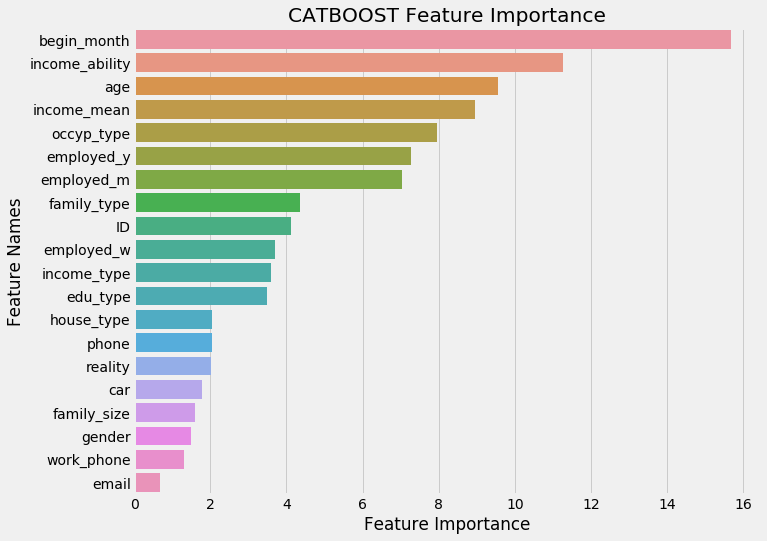

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

- 최종 예측 및 제출

In [ ]:
submit.iloc[:, 1:] = cat_pred_test
submit

,index,0,1,2
0,26457,0.073084,0.098309,0.828607
1,26458,0.176537,0.244232,0.579231
2,26459,0.132912,0.179491,0.687598
3,26460,0.187626,0.084623,0.727752
4,26461,0.146245,0.148456,0.705299
...,...,...,...,...
9995,36452,0.155012,0.199068,0.645920
9996,36453,0.133841,0.315880,0.550279
9997,36454,0.036928,0.144139,0.818933
9998,36455,0.063962,0.165216,0.770822


In [ ]:
submit.to_csv("model_cat_feature_add.csv",index=False)